# Experiment 7: MLP network using custom trained Word2Vec embeddings

Lets build on our last experiment with fully connected feedforward networks (MLP) by instead training it on the Word2Vec word embeddings we created using gensim in the word_embeddings notebook in the parent directory.
To do this, we first load in our data and our embedding vector model, and create a new network architecture to accept this pre-trained model as the first layer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scripts import word_normalization as wn
from keras.preprocessing import text
from exp4_data_feature_extraction import get_balanced_dataset
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import regularizers
import gensim

Using TensorFlow backend.


Our word embedding vector is over the entire dataset, but we only want a subset of this data. Let's use 20,000 reviews from our dataset.

In [2]:
all_reviews, fake_reviews, genuine_reviews, unused_genuine_reviews = get_balanced_dataset()
review_subset = all_reviews[:50000]

X = [x.review_content for x in review_subset]
y = np.array([x.label for x in review_subset])

X_train, X_test, y_train, y_test = train_test_split(X, y)

Now we load our gensim embedding model in and create an embedding matrix of our reviews on it.

In [3]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load('../../wordvec/yelp_w2v.kv', mmap='r')

In [4]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print(vocab_size)

51634


In [5]:
embedding_dim = word_vectors.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word_vectors.wv.vocab:
        embedding_matrix[i] = np.array(word_vectors.wv[word], dtype=np.float32)
        
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements/vocab_size)
print(embedding_matrix.shape)

0.7867877754967657
(51634, 100)


In [6]:
maxlen = max([len(x) for x in X_train_seq + X_test_seq])

print(maxlen)

X_train = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

1005


Because our word embeddings have already been trained, we don't need to train the layer.

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=8)

model_no_embed_train = keras.Sequential([
keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
keras.layers.GlobalMaxPool1D(),
keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)),
keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model_no_embed_train.summary()
model_no_embed_train.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_noembedtrain = model_no_embed_train.fit(X_train, y_train, 
          epochs=50, 
          batch_size=256, 
          validation_split=0.3, 
          verbose=1,
          callbacks=[early_stop])

scores = model_no_embed_train.evaluate(X_test, y_test, verbose=1)
print(model_no_embed_train.metrics_names, scores)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1005, 100)         5163400   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                3232      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,166,665
Trainable params: 3,265
Non-trainable params: 5,163,400
_________________________________________________________________
Train on 26250 samples, validate on 11250 samples
Epoch 1/50
26250/26250 [==============================] - 5s 175us/step - loss: 1.2040 - acc: 0.5193 - val_loss: 1.0831 - val_acc: 0.5272
Epoch 2/50
26250/26250 [==============================] - 4s 156us/step 

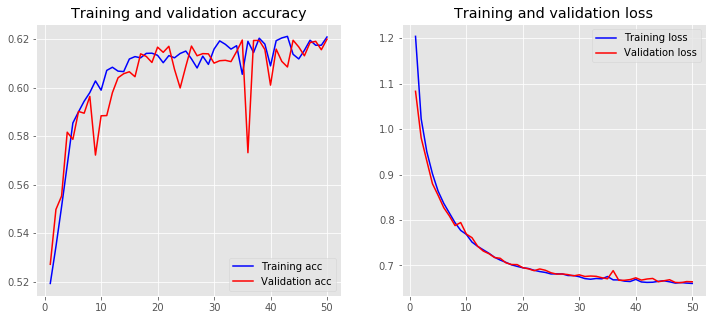

In [8]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history_noembedtrain)

In [9]:
model_embed_train = keras.Sequential([
keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True),
keras.layers.GlobalMaxPool1D(),
keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)),
keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model_embed_train.summary()
model_embed_train.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history_embedtrain = model_embed_train.fit(X_train, y_train, 
          epochs=50,
          batch_size=1024, 
          validation_split=0.3, 
          verbose=1,
          callbacks=[early_stop])
scores = model_embed_train.evaluate(X_test, y_test, verbose=1)
print(model_embed_train.metrics_names, scores)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1005, 100)         5163400   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,166,665
Trainable params: 5,166,665
Non-trainable params: 0
_________________________________________________________________


/home/stefan/miniconda3/envs/lucas/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26250 samples, validate on 11250 samples
Epoch 1/50
26250/26250 [==============================] - 99s 4ms/step - loss: 2.5777 - acc: 0.4998 - val_loss: 1.5628 - val_acc: 0.4818
Epoch 2/50
26250/26250 [==============================] - 102s 4ms/step - loss: 1.3308 - acc: 0.5016 - val_loss: 1.2469 - val_acc: 0.5031
Epoch 3/50
26250/26250 [==============================] - 100s 4ms/step - loss: 1.1957 - acc: 0.5100 - val_loss: 1.1659 - val_acc: 0.5173
Epoch 4/50
26250/26250 [==============================] - 108s 4ms/step - loss: 1.1413 - acc: 0.5264 - val_loss: 1.1304 - val_acc: 0.5211
Epoch 5/50
26250/26250 [==============================] - 109s 4ms/step - loss: 1.1098 - acc: 0.5319 - val_loss: 1.1027 - val_acc: 0.5302
Epoch 6/50
26250/26250 [==============================] - 108s 4ms/step - loss: 1.0848 - acc: 0.5398 - val_loss: 1.0802 - val_acc: 0.5363
Epoch 7/50
26250/26250 [==============================] - 100s 4ms/step - loss: 1.0636 - acc: 0.5431 - val_loss: 1.0606 - v

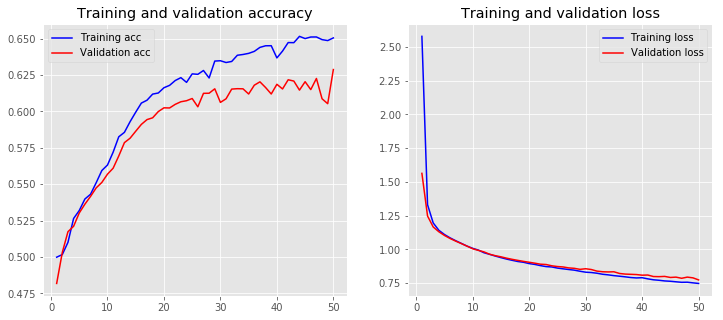

In [10]:
plot_history(history_embedtrain)